# Training

In [ ]:
!pip install pytorch-widedeep

In [ ]:
from pytorch_widedeep.models import FTTransformer, WideDeep, TabMlp
from pytorch_widedeep.preprocessing import TabPreprocessor
from pytorch_widedeep import Trainer
from pytorch_widedeep.metrics import Accuracy, F1Score, Precision, Recall
import pandas as pd
import torch

In [3]:
df = pd.read_csv('train_data.csv')

In [5]:
synthetic_data = pd.read_csv('synthetic_data.csv')

In [ ]:
synthetic_data_label_1 = synthetic_data[synthetic_data['Label'] == 1].sample(n=252707, random_state=42)
df_combined = pd.concat([df, synthetic_data_label_1])
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
target = df_combined['Label'].values
df_combined.drop(columns=['Label'], axis=1, inplace=True)
cat_cols = ['Cause', 'Proto', 'State', 'sDSb']
cont_cols = df_combined.drop(columns=cat_cols, axis=1).columns

In [9]:
attention = True # @param {type:"boolean"}

In [10]:
if attention:
    tab_preprocessor = TabPreprocessor(cat_embed_cols=cat_cols, continuous_cols=cont_cols, with_attention=True)
else:
    tab_preprocessor = TabPreprocessor(cat_embed_cols=cat_cols, continuous_cols=cont_cols)

X_tab = tab_preprocessor.fit_transform(df_combined)

/usr/local/lib/python3.10/dist-packages/pytorch_widedeep/preprocessing/tab_preprocessor.py:334: UserWarning: Continuous columns will not be normalised
  warnings.warn("Continuous columns will not be normalised")


In [11]:
if attention:
    base_model = FTTransformer(
                    column_idx=tab_preprocessor.column_idx,
                    cat_embed_input=tab_preprocessor.cat_embed_input,
                    continuous_cols=cont_cols,
                    cont_norm_layer='batchnorm'
                )

else:
    base_model = TabMlp(
                    column_idx=tab_preprocessor.column_idx,
                    cat_embed_input=tab_preprocessor.cat_embed_input,
                    continuous_cols=cont_cols,
                    mlp_hidden_dims=[1]
                )

model = WideDeep(deeptabular=base_model)

In [ ]:
model

WideDeep(
  (deeptabular): Sequential(
    (0): FTTransformer(
      (cat_and_cont_embed): SameSizeCatAndContEmbeddings(
        (cat_embed): SameSizeCatEmbeddings(
          (embed): Embedding(36, 64, padding_idx=0)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (cont_norm): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (cont_embed): ContEmbeddings(12, 64, embed_dropout=0.1, use_bias=True)
      )
      (encoder): Sequential(
        (fttransformer_block0): FTTransformerEncoder(
          (attn): LinearAttentionLinformer(
            (dropout): Dropout(p=0.2, inplace=False)
            (qkv_proj): Linear(in_features=64, out_features=192, bias=False)
            (out_proj): Linear(in_features=64, out_features=64, bias=False)
          )
          (ff): FeedForward(
            (w_1): Linear(in_features=64, out_features=170, bias=True)
            (w_2): Linear(in_features=85, out_features=64, bias=True)
            (dropou

In [ ]:
trainer = Trainer(
    model,
    objective="binary",
    metrics=[Accuracy, F1Score],
    num_workers=0
)
trainer.fit(X_tab=X_tab, target=target, n_epochs=30, batch_size=256)

epoch 30: 100%|██████████| 5595/5595 [02:26<00:00, 38.09it/s, loss=0.0175, metrics={'acc': 0.9951, 'f1': 0.9951}]


In [ ]:
torch.save(model.state_dict(), "ft_transformer_state_dict.pt")

# Evaluation

In [12]:
model.load_state_dict(torch.load("drive/MyDrive/models/ft_transformer_4oct_state_dict.pt"))


<All keys matched successfully>

In [13]:
trainer = Trainer(
    model,
    objective="binary",
    num_workers=0
)

In [14]:
test = pd.read_csv('test_data.csv')

In [ ]:
X_test_tab = tab_preprocessor.transform(test)
y_test = test.Label

In [16]:
preds = trainer.predict(X_tab=X_test_tab)

predict:   0%|          | 0/143 [00:00<?, ?it/s]<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
predict: 100%|██████████| 143/143 [00:04<00:00, 29.69it/s]


In [17]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [18]:
accuracy_score(y_test, preds)

0.9985744441702991

In [19]:
f1_score(y_test, preds)

0.9981944444444445

In [20]:
precision_score(y_test, preds)

0.9970865704772475

In [21]:
recall_score(y_test, preds)

0.9993047830923248

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

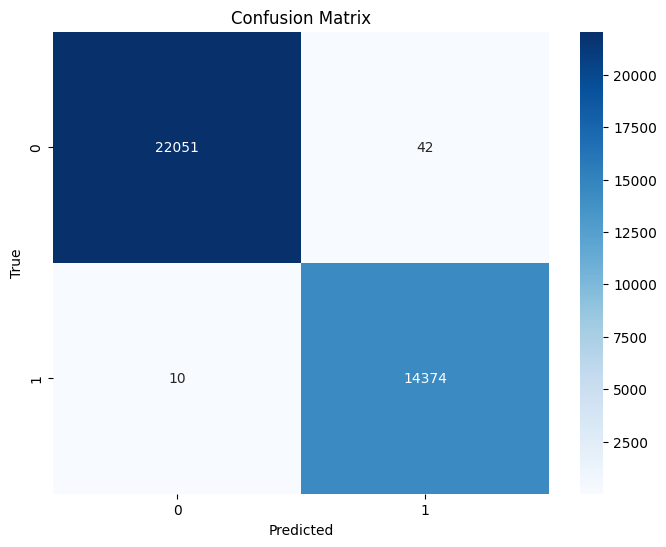

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics

cm = confusion_matrix(y_test, preds)

# Plot as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

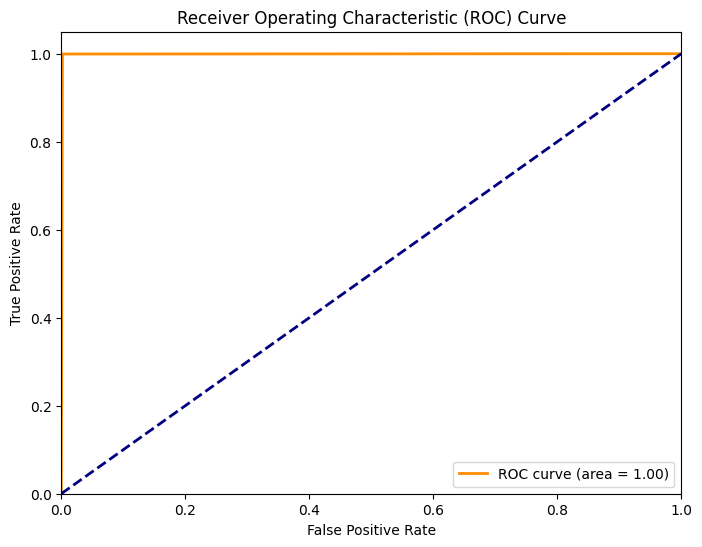

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_test and preds are your arrays
# Replace them with your actual data

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [24]:
misclassified_indices = np.where(y_test != preds)[0]

In [26]:
miss_df = pd.concat([tab_preprocessor.inverse_transform(X_test_tab).iloc[misclassified_indices], y_test[misclassified_indices]], axis=1)

In [27]:
miss_df['Label'] = miss_df['Label'].map({0: 'Malicious', 1: 'Benign'})

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


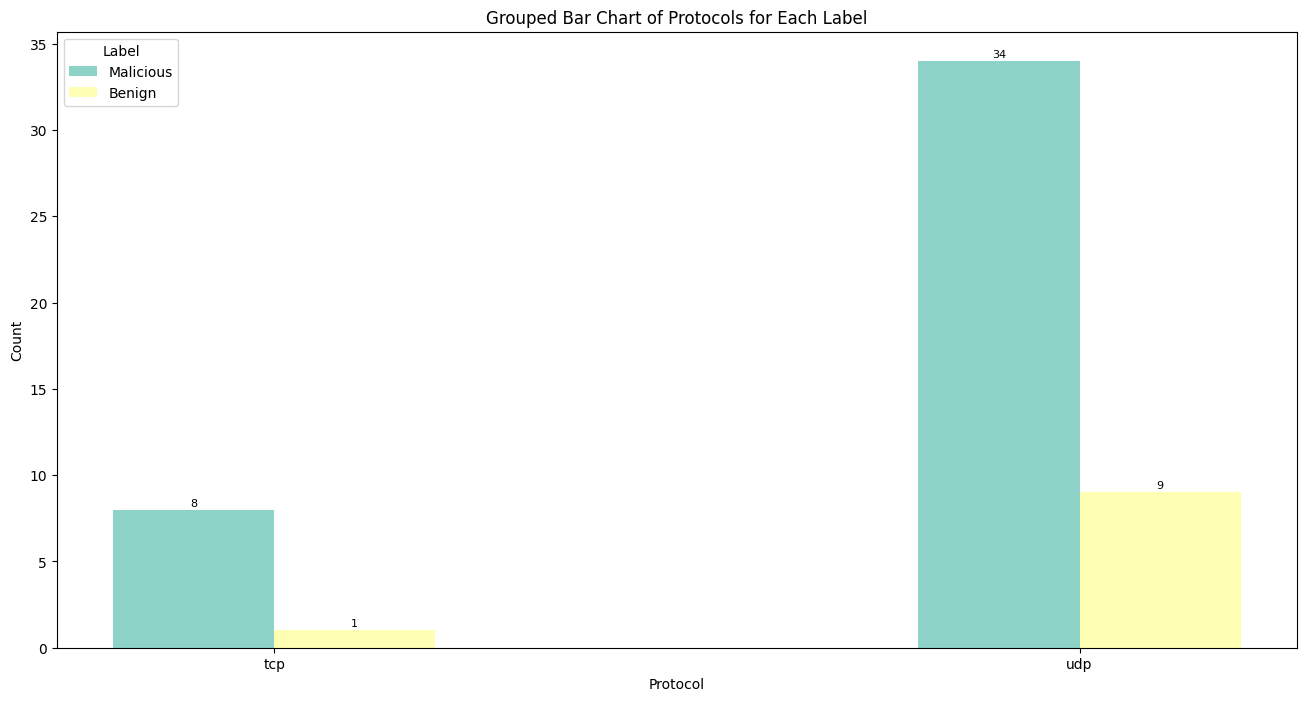

In [29]:
proto_label_counts = miss_df.groupby(['Proto', 'Label']).size().unstack(fill_value=0)

# Generate a list of unique colors based on the number of labels
colors = plt.cm.Set3(range(len(miss_df['Label'].unique())))

# Plotting a grouped bar chart with adjusted size
plt.figure(figsize=(16, 8))
bar_width = 0.2
bar_positions = np.arange(len(proto_label_counts))

for i, label in enumerate(miss_df['Label'].unique()):
    plt.bar(bar_positions + i * bar_width, proto_label_counts[label], width=bar_width, label=label, color=colors[i])

# Adding labels and title
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.title('Grouped Bar Chart of Protocols for Each Label')

# Adding legend
plt.legend(loc='upper left', title='Label')

# Adjust x-axis ticks and labels
plt.xticks(bar_positions + (len(miss_df['Label'].unique()) - 1) * bar_width / 2, proto_label_counts.index)

# Increasing the length of count labels
for i, label in enumerate(miss_df['Label'].unique()):
    for j, count in enumerate(proto_label_counts[label]):
        plt.text(bar_positions[j] + i * bar_width, count + 0.1, str(count), ha='center', va='bottom', fontsize=8)

plt.show()

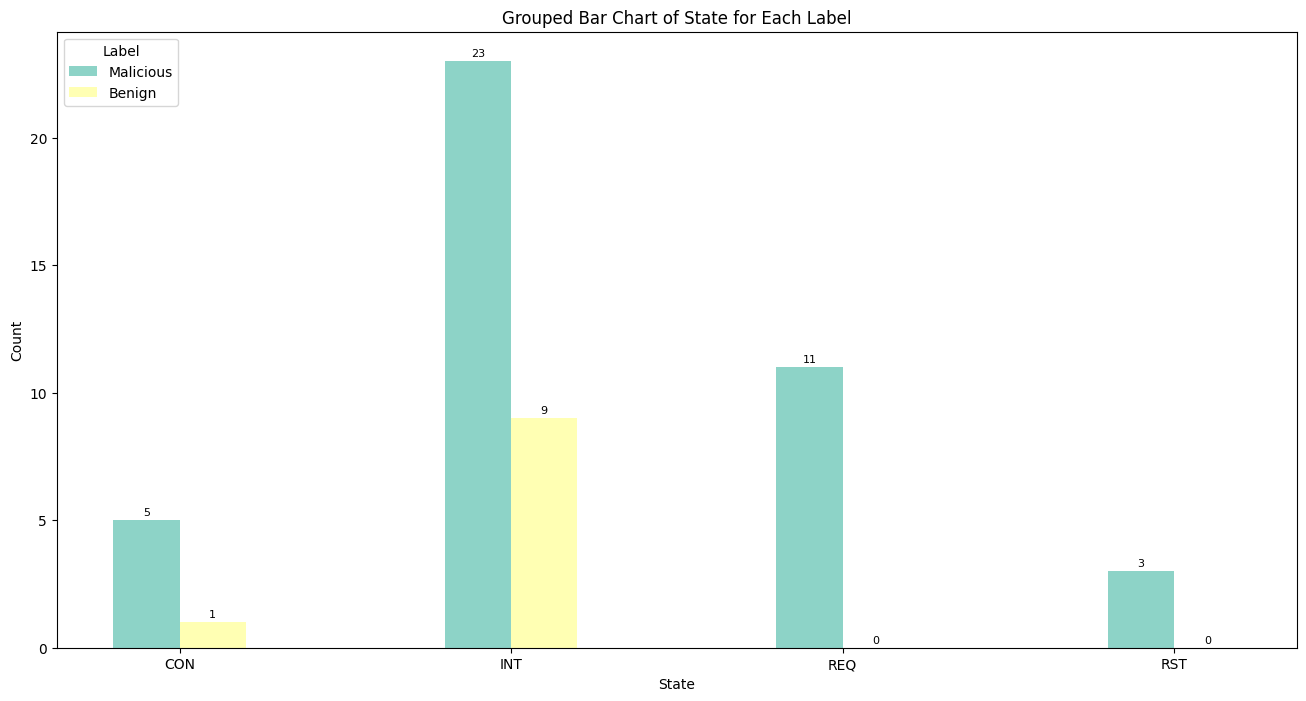

In [30]:
State_label_counts = miss_df.groupby(['State', 'Label']).size().unstack(fill_value=0)

# Generate a list of unique colors based on the number of labels
colors = plt.cm.Set3(range(len(miss_df['Label'].unique())))

# Plotting a grouped bar chart with adjusted size
plt.figure(figsize=(16, 8))
bar_width = 0.2
bar_positions = np.arange(len(State_label_counts))

for i, label in enumerate(miss_df['Label'].unique()):
    plt.bar(bar_positions + i * bar_width, State_label_counts[label], width=bar_width, label=label, color=colors[i])

# Adding labels and title
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Grouped Bar Chart of State for Each Label')

# Adding legend
plt.legend(loc='upper left', title='Label')

# Adjust x-axis ticks and labels
plt.xticks(bar_positions + (len(miss_df['Label'].unique()) - 1) * bar_width / 2, State_label_counts.index)

# Increasing the length of count labels
for i, label in enumerate(miss_df['Label'].unique()):
    for j, count in enumerate(State_label_counts[label]):
        plt.text(bar_positions[j] + i * bar_width, count + 0.1, str(count), ha='center', va='bottom', fontsize=8)

plt.show()

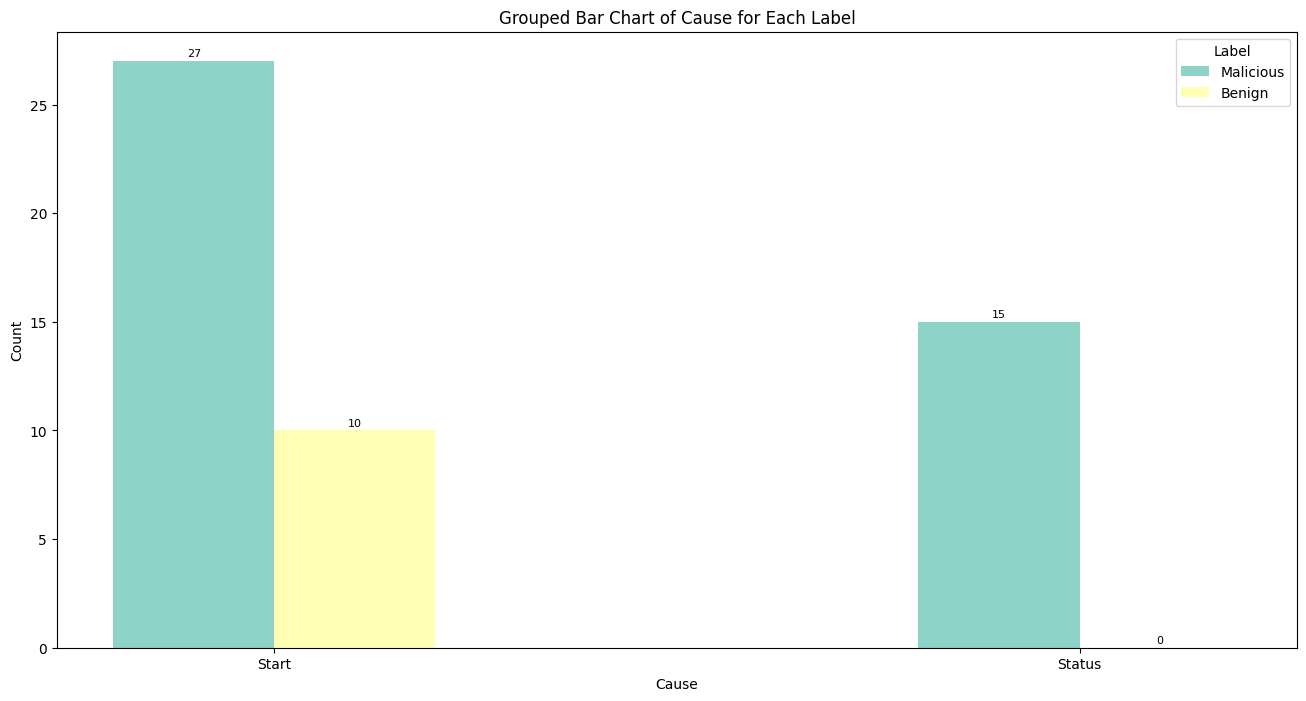

In [31]:
Cause_label_counts = miss_df.groupby(['Cause', 'Label']).size().unstack(fill_value=0)

# Generate a list of unique colors based on the number of labels
colors = plt.cm.Set3(range(len(miss_df['Label'].unique())))

# Plotting a grouped bar chart with adjusted size
plt.figure(figsize=(16, 8))
bar_width = 0.2
bar_positions = np.arange(len(Cause_label_counts))

for i, label in enumerate(miss_df['Label'].unique()):
    plt.bar(bar_positions + i * bar_width, Cause_label_counts[label], width=bar_width, label=label, color=colors[i])

# Adding labels and title
plt.xlabel('Cause')
plt.ylabel('Count')
plt.title('Grouped Bar Chart of Cause for Each Label')

# Adding legend
plt.legend(loc='upper right', title='Label')

# Adjust x-axis ticks and labels
plt.xticks(bar_positions + (len(miss_df['Label'].unique()) - 1) * bar_width / 2, Cause_label_counts.index)

# Increasing the length of count labels
for i, label in enumerate(miss_df['Label'].unique()):
    for j, count in enumerate(Cause_label_counts[label]):
        plt.text(bar_positions[j] + i * bar_width, count + 0.1, str(count), ha='center', va='bottom', fontsize=8)

plt.show()